In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import cv2

# pytorch
import torch # ; print('Using torch version -', torch.__version__)
if torch.cuda.is_available():
    print('CUDA is available')
    device = 'cuda'
else:
    print('CUDA NOT available')
    device = 'cpu'
from torch.nn import Module, Conv2d, ReLU, ModuleList, MaxPool2d, ConvTranspose2d, BCELoss, BCEWithLogitsLoss, functional as F
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset, DataLoader

# warning
import warnings
warnings.filterwarnings('ignore')

CUDA is available


In [2]:
path_dataset = "../Data/Sample/AOI_2_Vegas_Roads_Sample/"
path_images = path_dataset + "PS-RGB_8bit_png/"
path_masks = path_dataset + "masks_2m/"
path_base_output = path_dataset + "OUTPUTS/"

plot_path = path_base_output+'plot.png'
model_path = path_base_output+'unet.pth'
test_paths = path_base_output+'test_paths.txt'

img_files = os.listdir(path_images)
print(img_files[0])

RGB-PanSharpen_AOI_2_Vegas_img1454.png


In [3]:
class SpaceNet3Dataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(path_images+imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(path_masks+self.maskPaths[idx], 0)
        mask = np.where(mask>0, 255, 0)
        mask = mask.astype(image.dtype)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        return (image, mask)

In [4]:
imagePaths = sorted(list(os.listdir(path_images)))
maskPaths = sorted(list(os.listdir(path_masks)))

for i in range(10):
    im_ = imagePaths[i].split('_')[-1].split('.')[0]
    ms_ = maskPaths[i].split('_')[-1].split('.')[0]
    assert(im_==ms_)
#     print('image:', im_, '\t| mask:', ms_)

In [5]:
trainImages, testImages, trainMasks, testMasks = train_test_split(imagePaths, maskPaths, test_size=0.2, random_state=42)

# train images
assert(len(trainImages)==len(trainMasks))
for i in range(len(trainImages)):
    im_ = trainImages[i].split('_')[-1].split('.')[0]
    ms_ = trainMasks[i].split('_')[-1].split('.')[0]
#     print(im_, ms_)
    assert(im_==ms_)
    
# test images
assert(len(testImages)==len(testMasks))
for i in range(len(testImages)):
    im_ = testImages[i].split('_')[-1].split('.')[0]
    ms_ = testMasks[i].split('_')[-1].split('.')[0]
#     print(im_, ms_)
    assert(im_==ms_)

In [6]:
height, width = 512, 512

# define transformations
transforms_ = transforms.Compose([transforms.ToPILImage(), 
                                 transforms.Resize((height,width)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SpaceNet3Dataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SpaceNet3Dataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
batch_size = 1
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size)

[INFO] found 8 examples in the training set...
[INFO] found 2 examples in the test set...


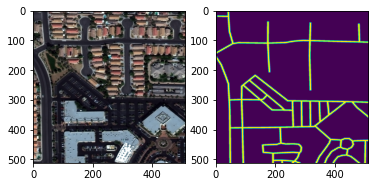

In [7]:
t_img, t_lb = next(iter(trainLoader))
fig,ax=plt.subplots(1,2)
ax[0].imshow(t_img[0].permute(1,2,0))
ax[1].imshow(t_lb[0][0])

# Model

In [8]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [9]:
class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

In [10]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [11]:
class UNet(Module):
    def __init__(self, encChannels=(3, 64, 128, 256, 512, 1024), decChannels=(1024, 512, 256, 128, 64),
                 nbClasses=1, retainDim=True, outSize=(height, width)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map_ = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map_ = F.interpolate(map_, self.outSize)
        # return the segmentation map
        return map_

In [12]:
# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss(pos_weight=torch.ones([1])).cuda()
opt = Adam(unet.parameters(), lr=0.0001)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [13]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
num_epochs =  5000
for e in tqdm(range(num_epochs), total=num_epochs):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        y_=y.detach().cpu()
        loss = lossFunc(pred, y.float())
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y.float())
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/5000 [00:00<?, ?it/s]

[INFO] EPOCH: 1/5000
Train loss: 0.684151, Test loss: 0.6363
[INFO] EPOCH: 2/5000
Train loss: 0.523210, Test loss: 0.4915
[INFO] EPOCH: 3/5000
Train loss: 0.306325, Test loss: 0.2727
[INFO] EPOCH: 4/5000
Train loss: 0.262362, Test loss: 0.2737
[INFO] EPOCH: 5/5000
Train loss: 0.266583, Test loss: 0.2875
[INFO] EPOCH: 6/5000
Train loss: 0.257036, Test loss: 0.2815
[INFO] EPOCH: 7/5000
Train loss: 0.267110, Test loss: 0.2980
[INFO] EPOCH: 8/5000
Train loss: 0.252199, Test loss: 0.2806
[INFO] EPOCH: 9/5000
Train loss: 0.250384, Test loss: 0.2910
[INFO] EPOCH: 10/5000
Train loss: 0.248503, Test loss: 0.2849
[INFO] EPOCH: 11/5000
Train loss: 0.252031, Test loss: 0.3044
[INFO] EPOCH: 12/5000
Train loss: 0.261985, Test loss: 0.2863
[INFO] EPOCH: 13/5000
Train loss: 0.267707, Test loss: 0.3023
[INFO] EPOCH: 14/5000
Train loss: 0.294124, Test loss: 0.2804
[INFO] EPOCH: 15/5000
Train loss: 0.262124, Test loss: 0.2889
[INFO] EPOCH: 16/5000
Train loss: 0.254854, Test loss: 0.2785
[INFO] EPOCH: 17/

[INFO] EPOCH: 133/5000
Train loss: 0.234852, Test loss: 0.2950
[INFO] EPOCH: 134/5000
Train loss: 0.233958, Test loss: 0.3387
[INFO] EPOCH: 135/5000
Train loss: 0.237200, Test loss: 0.2701
[INFO] EPOCH: 136/5000
Train loss: 0.232680, Test loss: 0.2752
[INFO] EPOCH: 137/5000
Train loss: 0.228078, Test loss: 0.3151
[INFO] EPOCH: 138/5000
Train loss: 0.225303, Test loss: 0.3267
[INFO] EPOCH: 139/5000
Train loss: 0.219893, Test loss: 0.2955
[INFO] EPOCH: 140/5000
Train loss: 0.220779, Test loss: 0.2985
[INFO] EPOCH: 141/5000
Train loss: 0.217180, Test loss: 0.3175
[INFO] EPOCH: 142/5000
Train loss: 0.218084, Test loss: 0.3234
[INFO] EPOCH: 143/5000
Train loss: 0.216208, Test loss: 0.3000
[INFO] EPOCH: 144/5000
Train loss: 0.217017, Test loss: 0.2863
[INFO] EPOCH: 145/5000
Train loss: 0.222052, Test loss: 0.2931
[INFO] EPOCH: 146/5000
Train loss: 0.217641, Test loss: 0.3360
[INFO] EPOCH: 147/5000
Train loss: 0.215033, Test loss: 0.3416
[INFO] EPOCH: 148/5000
Train loss: 0.212497, Test loss:

[INFO] EPOCH: 264/5000
Train loss: 0.036057, Test loss: 1.4461
[INFO] EPOCH: 265/5000
Train loss: 0.035551, Test loss: 1.3980
[INFO] EPOCH: 266/5000
Train loss: 0.033287, Test loss: 1.3539
[INFO] EPOCH: 267/5000
Train loss: 0.031898, Test loss: 1.5792
[INFO] EPOCH: 268/5000
Train loss: 0.031435, Test loss: 1.4808
[INFO] EPOCH: 269/5000
Train loss: 0.030783, Test loss: 1.5364
[INFO] EPOCH: 270/5000
Train loss: 0.032773, Test loss: 1.3896
[INFO] EPOCH: 271/5000
Train loss: 0.030797, Test loss: 1.5350
[INFO] EPOCH: 272/5000
Train loss: 0.030475, Test loss: 1.5472
[INFO] EPOCH: 273/5000
Train loss: 0.031164, Test loss: 1.5356
[INFO] EPOCH: 274/5000
Train loss: 0.032555, Test loss: 1.5646
[INFO] EPOCH: 275/5000
Train loss: 0.032411, Test loss: 1.3828
[INFO] EPOCH: 276/5000
Train loss: 0.033346, Test loss: 1.3624
[INFO] EPOCH: 277/5000
Train loss: 0.033671, Test loss: 1.4411
[INFO] EPOCH: 278/5000
Train loss: 0.031965, Test loss: 1.3480
[INFO] EPOCH: 279/5000
Train loss: 0.033621, Test loss:

[INFO] EPOCH: 395/5000
Train loss: 0.025424, Test loss: 1.4339
[INFO] EPOCH: 396/5000
Train loss: 0.025684, Test loss: 1.4538
[INFO] EPOCH: 397/5000
Train loss: 0.025093, Test loss: 1.4703
[INFO] EPOCH: 398/5000
Train loss: 0.024964, Test loss: 1.4988
[INFO] EPOCH: 399/5000
Train loss: 0.024968, Test loss: 1.5051
[INFO] EPOCH: 400/5000
Train loss: 0.025005, Test loss: 1.4960
[INFO] EPOCH: 401/5000
Train loss: 0.025626, Test loss: 1.4821
[INFO] EPOCH: 402/5000
Train loss: 0.025512, Test loss: 1.4924
[INFO] EPOCH: 403/5000
Train loss: 0.025923, Test loss: 1.4469
[INFO] EPOCH: 404/5000
Train loss: 0.025728, Test loss: 1.4367
[INFO] EPOCH: 405/5000
Train loss: 0.025754, Test loss: 1.4404
[INFO] EPOCH: 406/5000
Train loss: 0.025599, Test loss: 1.4233
[INFO] EPOCH: 407/5000
Train loss: 0.025795, Test loss: 1.4681
[INFO] EPOCH: 408/5000
Train loss: 0.025895, Test loss: 1.4044
[INFO] EPOCH: 409/5000
Train loss: 0.027322, Test loss: 1.3962
[INFO] EPOCH: 410/5000
Train loss: 0.028002, Test loss:

[INFO] EPOCH: 526/5000
Train loss: 0.025510, Test loss: 1.5749
[INFO] EPOCH: 527/5000
Train loss: 0.025867, Test loss: 1.5335
[INFO] EPOCH: 528/5000
Train loss: 0.025838, Test loss: 1.5192
[INFO] EPOCH: 529/5000
Train loss: 0.026418, Test loss: 1.5187
[INFO] EPOCH: 530/5000
Train loss: 0.026097, Test loss: 1.5100
[INFO] EPOCH: 531/5000
Train loss: 0.027411, Test loss: 1.4261
[INFO] EPOCH: 532/5000
Train loss: 0.026020, Test loss: 1.4580
[INFO] EPOCH: 533/5000
Train loss: 0.025978, Test loss: 1.5292
[INFO] EPOCH: 534/5000
Train loss: 0.025445, Test loss: 1.5240
[INFO] EPOCH: 535/5000
Train loss: 0.025452, Test loss: 1.5316
[INFO] EPOCH: 536/5000
Train loss: 0.025171, Test loss: 1.5925
[INFO] EPOCH: 537/5000
Train loss: 0.025569, Test loss: 1.5359
[INFO] EPOCH: 538/5000
Train loss: 0.025223, Test loss: 1.5056
[INFO] EPOCH: 539/5000
Train loss: 0.025174, Test loss: 1.5844
[INFO] EPOCH: 540/5000
Train loss: 0.025709, Test loss: 1.5512
[INFO] EPOCH: 541/5000
Train loss: 0.026060, Test loss:

[INFO] EPOCH: 657/5000
Train loss: 0.024089, Test loss: 1.6475
[INFO] EPOCH: 658/5000
Train loss: 0.024250, Test loss: 1.6443
[INFO] EPOCH: 659/5000
Train loss: 0.024195, Test loss: 1.6404
[INFO] EPOCH: 660/5000
Train loss: 0.024266, Test loss: 1.6547
[INFO] EPOCH: 661/5000
Train loss: 0.024353, Test loss: 1.6157
[INFO] EPOCH: 662/5000
Train loss: 0.024246, Test loss: 1.6490
[INFO] EPOCH: 663/5000
Train loss: 0.024315, Test loss: 1.6206
[INFO] EPOCH: 664/5000
Train loss: 0.024275, Test loss: 1.6395
[INFO] EPOCH: 665/5000
Train loss: 0.024369, Test loss: 1.6137
[INFO] EPOCH: 666/5000
Train loss: 0.024475, Test loss: 1.6550
[INFO] EPOCH: 667/5000
Train loss: 0.025078, Test loss: 1.5476
[INFO] EPOCH: 668/5000
Train loss: 0.025222, Test loss: 1.4693
[INFO] EPOCH: 669/5000
Train loss: 0.025844, Test loss: 1.4472
[INFO] EPOCH: 670/5000
Train loss: 0.026302, Test loss: 1.4419
[INFO] EPOCH: 671/5000
Train loss: 0.025855, Test loss: 1.3462
[INFO] EPOCH: 672/5000
Train loss: 0.027486, Test loss:

[INFO] EPOCH: 788/5000
Train loss: 0.024590, Test loss: 1.5076
[INFO] EPOCH: 789/5000
Train loss: 0.024586, Test loss: 1.4458
[INFO] EPOCH: 790/5000
Train loss: 0.024344, Test loss: 1.4975
[INFO] EPOCH: 791/5000
Train loss: 0.024529, Test loss: 1.5249
[INFO] EPOCH: 792/5000
Train loss: 0.024763, Test loss: 1.4647
[INFO] EPOCH: 793/5000
Train loss: 0.024831, Test loss: 1.4390
[INFO] EPOCH: 794/5000
Train loss: 0.025007, Test loss: 1.4797
[INFO] EPOCH: 795/5000
Train loss: 0.024438, Test loss: 1.4581
[INFO] EPOCH: 796/5000
Train loss: 0.024598, Test loss: 1.5222
[INFO] EPOCH: 797/5000
Train loss: 0.024521, Test loss: 1.4746
[INFO] EPOCH: 798/5000
Train loss: 0.024887, Test loss: 1.4533
[INFO] EPOCH: 799/5000
Train loss: 0.024503, Test loss: 1.4646
[INFO] EPOCH: 800/5000
Train loss: 0.024160, Test loss: 1.5399
[INFO] EPOCH: 801/5000
Train loss: 0.024165, Test loss: 1.5741
[INFO] EPOCH: 802/5000
Train loss: 0.024062, Test loss: 1.5165
[INFO] EPOCH: 803/5000
Train loss: 0.024059, Test loss:

[INFO] EPOCH: 919/5000
Train loss: 0.028919, Test loss: 1.0533
[INFO] EPOCH: 920/5000
Train loss: 0.028928, Test loss: 0.9898
[INFO] EPOCH: 921/5000
Train loss: 0.028150, Test loss: 1.0435
[INFO] EPOCH: 922/5000
Train loss: 0.027546, Test loss: 1.0223
[INFO] EPOCH: 923/5000
Train loss: 0.026729, Test loss: 1.0703
[INFO] EPOCH: 924/5000
Train loss: 0.026002, Test loss: 1.0638
[INFO] EPOCH: 925/5000
Train loss: 0.025927, Test loss: 1.1137
[INFO] EPOCH: 926/5000
Train loss: 0.025762, Test loss: 1.0836
[INFO] EPOCH: 927/5000
Train loss: 0.025536, Test loss: 1.1482
[INFO] EPOCH: 928/5000
Train loss: 0.025465, Test loss: 1.1138
[INFO] EPOCH: 929/5000
Train loss: 0.025387, Test loss: 1.1447
[INFO] EPOCH: 930/5000
Train loss: 0.025405, Test loss: 1.1128
[INFO] EPOCH: 931/5000
Train loss: 0.025574, Test loss: 1.1438
[INFO] EPOCH: 932/5000
Train loss: 0.025619, Test loss: 1.1307
[INFO] EPOCH: 933/5000
Train loss: 0.025607, Test loss: 1.1255
[INFO] EPOCH: 934/5000
Train loss: 0.026194, Test loss:

[INFO] EPOCH: 1049/5000
Train loss: 0.024241, Test loss: 1.2056
[INFO] EPOCH: 1050/5000
Train loss: 0.024248, Test loss: 1.1870
[INFO] EPOCH: 1051/5000
Train loss: 0.024196, Test loss: 1.2093
[INFO] EPOCH: 1052/5000
Train loss: 0.024200, Test loss: 1.1862
[INFO] EPOCH: 1053/5000
Train loss: 0.024214, Test loss: 1.2073
[INFO] EPOCH: 1054/5000
Train loss: 0.024218, Test loss: 1.2138
[INFO] EPOCH: 1055/5000
Train loss: 0.024154, Test loss: 1.1983
[INFO] EPOCH: 1056/5000
Train loss: 0.024169, Test loss: 1.2061
[INFO] EPOCH: 1057/5000
Train loss: 0.024147, Test loss: 1.2223
[INFO] EPOCH: 1058/5000
Train loss: 0.024177, Test loss: 1.2199
[INFO] EPOCH: 1059/5000
Train loss: 0.024148, Test loss: 1.2150
[INFO] EPOCH: 1060/5000
Train loss: 0.024148, Test loss: 1.2227
[INFO] EPOCH: 1061/5000
Train loss: 0.024182, Test loss: 1.2263
[INFO] EPOCH: 1062/5000
Train loss: 0.024205, Test loss: 1.2192
[INFO] EPOCH: 1063/5000
Train loss: 0.024194, Test loss: 1.2091
[INFO] EPOCH: 1064/5000
Train loss: 0.02

[INFO] EPOCH: 1178/5000
Train loss: 0.026046, Test loss: 1.0566
[INFO] EPOCH: 1179/5000
Train loss: 0.025761, Test loss: 1.0404
[INFO] EPOCH: 1180/5000
Train loss: 0.025563, Test loss: 1.0559
[INFO] EPOCH: 1181/5000
Train loss: 0.025067, Test loss: 1.1242
[INFO] EPOCH: 1182/5000
Train loss: 0.024587, Test loss: 1.1140
[INFO] EPOCH: 1183/5000
Train loss: 0.024430, Test loss: 1.1425
[INFO] EPOCH: 1184/5000
Train loss: 0.024182, Test loss: 1.1847
[INFO] EPOCH: 1185/5000
Train loss: 0.024095, Test loss: 1.1801
[INFO] EPOCH: 1186/5000
Train loss: 0.023984, Test loss: 1.2101
[INFO] EPOCH: 1187/5000
Train loss: 0.023997, Test loss: 1.2002
[INFO] EPOCH: 1188/5000
Train loss: 0.023963, Test loss: 1.2267
[INFO] EPOCH: 1189/5000
Train loss: 0.023961, Test loss: 1.2195
[INFO] EPOCH: 1190/5000
Train loss: 0.023938, Test loss: 1.2413
[INFO] EPOCH: 1191/5000
Train loss: 0.023937, Test loss: 1.2337
[INFO] EPOCH: 1192/5000
Train loss: 0.023935, Test loss: 1.2377
[INFO] EPOCH: 1193/5000
Train loss: 0.02

[INFO] EPOCH: 1307/5000
Train loss: 0.024196, Test loss: 1.2875
[INFO] EPOCH: 1308/5000
Train loss: 0.024165, Test loss: 1.2885
[INFO] EPOCH: 1309/5000
Train loss: 0.024139, Test loss: 1.3026
[INFO] EPOCH: 1310/5000
Train loss: 0.024118, Test loss: 1.2997
[INFO] EPOCH: 1311/5000
Train loss: 0.024101, Test loss: 1.3093
[INFO] EPOCH: 1312/5000
Train loss: 0.024087, Test loss: 1.3175
[INFO] EPOCH: 1313/5000
Train loss: 0.024071, Test loss: 1.3118
[INFO] EPOCH: 1314/5000
Train loss: 0.024055, Test loss: 1.3245
[INFO] EPOCH: 1315/5000
Train loss: 0.024041, Test loss: 1.3227
[INFO] EPOCH: 1316/5000
Train loss: 0.024030, Test loss: 1.3291
[INFO] EPOCH: 1317/5000
Train loss: 0.024018, Test loss: 1.3351
[INFO] EPOCH: 1318/5000
Train loss: 0.024010, Test loss: 1.3381
[INFO] EPOCH: 1319/5000
Train loss: 0.023999, Test loss: 1.3369
[INFO] EPOCH: 1320/5000
Train loss: 0.023995, Test loss: 1.3494
[INFO] EPOCH: 1321/5000
Train loss: 0.023983, Test loss: 1.3512
[INFO] EPOCH: 1322/5000
Train loss: 0.02

[INFO] EPOCH: 1436/5000
Train loss: 0.024334, Test loss: 1.2618
[INFO] EPOCH: 1437/5000
Train loss: 0.024314, Test loss: 1.2860
[INFO] EPOCH: 1438/5000
Train loss: 0.024202, Test loss: 1.3319
[INFO] EPOCH: 1439/5000
Train loss: 0.024068, Test loss: 1.3098
[INFO] EPOCH: 1440/5000
Train loss: 0.024152, Test loss: 1.3392
[INFO] EPOCH: 1441/5000
Train loss: 0.024096, Test loss: 1.3451
[INFO] EPOCH: 1442/5000
Train loss: 0.024246, Test loss: 1.3348
[INFO] EPOCH: 1443/5000
Train loss: 0.024133, Test loss: 1.3488
[INFO] EPOCH: 1444/5000
Train loss: 0.023953, Test loss: 1.3590
[INFO] EPOCH: 1445/5000
Train loss: 0.023890, Test loss: 1.3733
[INFO] EPOCH: 1446/5000
Train loss: 0.023876, Test loss: 1.3863
[INFO] EPOCH: 1447/5000
Train loss: 0.023831, Test loss: 1.4009
[INFO] EPOCH: 1448/5000
Train loss: 0.023821, Test loss: 1.4005
[INFO] EPOCH: 1449/5000
Train loss: 0.023821, Test loss: 1.4158
[INFO] EPOCH: 1450/5000
Train loss: 0.023845, Test loss: 1.4171
[INFO] EPOCH: 1451/5000
Train loss: 0.02

[INFO] EPOCH: 1565/5000
Train loss: 0.023734, Test loss: 1.4491
[INFO] EPOCH: 1566/5000
Train loss: 0.023761, Test loss: 1.4638
[INFO] EPOCH: 1567/5000
Train loss: 0.023737, Test loss: 1.4764
[INFO] EPOCH: 1568/5000
Train loss: 0.023735, Test loss: 1.4771
[INFO] EPOCH: 1569/5000
Train loss: 0.023786, Test loss: 1.4691
[INFO] EPOCH: 1570/5000
Train loss: 0.023800, Test loss: 1.4676
[INFO] EPOCH: 1571/5000
Train loss: 0.023772, Test loss: 1.4728
[INFO] EPOCH: 1572/5000
Train loss: 0.023715, Test loss: 1.4917
[INFO] EPOCH: 1573/5000
Train loss: 0.023721, Test loss: 1.4753
[INFO] EPOCH: 1574/5000
Train loss: 0.023717, Test loss: 1.4989
[INFO] EPOCH: 1575/5000
Train loss: 0.023672, Test loss: 1.5068
[INFO] EPOCH: 1576/5000
Train loss: 0.023647, Test loss: 1.4974
[INFO] EPOCH: 1577/5000
Train loss: 0.023645, Test loss: 1.5013
[INFO] EPOCH: 1578/5000
Train loss: 0.023672, Test loss: 1.5112
[INFO] EPOCH: 1579/5000
Train loss: 0.023656, Test loss: 1.5213
[INFO] EPOCH: 1580/5000
Train loss: 0.02

[INFO] EPOCH: 1694/5000
Train loss: 0.025483, Test loss: 1.1751
[INFO] EPOCH: 1695/5000
Train loss: 0.024924, Test loss: 1.2555
[INFO] EPOCH: 1696/5000
Train loss: 0.024683, Test loss: 1.2206
[INFO] EPOCH: 1697/5000
Train loss: 0.024498, Test loss: 1.3127
[INFO] EPOCH: 1698/5000
Train loss: 0.024633, Test loss: 1.2348
[INFO] EPOCH: 1699/5000
Train loss: 0.024201, Test loss: 1.3724
[INFO] EPOCH: 1700/5000
Train loss: 0.023974, Test loss: 1.3072
[INFO] EPOCH: 1701/5000
Train loss: 0.023802, Test loss: 1.3624
[INFO] EPOCH: 1702/5000
Train loss: 0.023710, Test loss: 1.4229
[INFO] EPOCH: 1703/5000
Train loss: 0.023677, Test loss: 1.3993
[INFO] EPOCH: 1704/5000
Train loss: 0.023651, Test loss: 1.4249
[INFO] EPOCH: 1705/5000
Train loss: 0.023628, Test loss: 1.4408
[INFO] EPOCH: 1706/5000
Train loss: 0.023617, Test loss: 1.4378
[INFO] EPOCH: 1707/5000
Train loss: 0.023625, Test loss: 1.4513
[INFO] EPOCH: 1708/5000
Train loss: 0.023645, Test loss: 1.4743
[INFO] EPOCH: 1709/5000
Train loss: 0.02

[INFO] EPOCH: 1823/5000
Train loss: 0.023651, Test loss: 1.6409
[INFO] EPOCH: 1824/5000
Train loss: 0.023649, Test loss: 1.6433
[INFO] EPOCH: 1825/5000
Train loss: 0.023646, Test loss: 1.6470
[INFO] EPOCH: 1826/5000
Train loss: 0.023644, Test loss: 1.6505
[INFO] EPOCH: 1827/5000
Train loss: 0.023641, Test loss: 1.6522
[INFO] EPOCH: 1828/5000
Train loss: 0.023639, Test loss: 1.6559
[INFO] EPOCH: 1829/5000
Train loss: 0.023636, Test loss: 1.6579
[INFO] EPOCH: 1830/5000
Train loss: 0.023634, Test loss: 1.6622
[INFO] EPOCH: 1831/5000
Train loss: 0.023633, Test loss: 1.6666
[INFO] EPOCH: 1832/5000
Train loss: 0.023630, Test loss: 1.6662
[INFO] EPOCH: 1833/5000
Train loss: 0.023627, Test loss: 1.6697
[INFO] EPOCH: 1834/5000
Train loss: 0.023625, Test loss: 1.6727
[INFO] EPOCH: 1835/5000
Train loss: 0.023623, Test loss: 1.6755
[INFO] EPOCH: 1836/5000
Train loss: 0.023621, Test loss: 1.6773
[INFO] EPOCH: 1837/5000
Train loss: 0.023619, Test loss: 1.6800
[INFO] EPOCH: 1838/5000
Train loss: 0.02

[INFO] EPOCH: 1952/5000
Train loss: 0.023541, Test loss: 1.6461
[INFO] EPOCH: 1953/5000
Train loss: 0.023539, Test loss: 1.6519
[INFO] EPOCH: 1954/5000
Train loss: 0.023537, Test loss: 1.6534
[INFO] EPOCH: 1955/5000
Train loss: 0.023535, Test loss: 1.6659
[INFO] EPOCH: 1956/5000
Train loss: 0.023534, Test loss: 1.6701
[INFO] EPOCH: 1957/5000
Train loss: 0.023532, Test loss: 1.6723
[INFO] EPOCH: 1958/5000
Train loss: 0.023530, Test loss: 1.6765
[INFO] EPOCH: 1959/5000
Train loss: 0.023529, Test loss: 1.6855
[INFO] EPOCH: 1960/5000
Train loss: 0.023528, Test loss: 1.6877
[INFO] EPOCH: 1961/5000
Train loss: 0.023526, Test loss: 1.6929
[INFO] EPOCH: 1962/5000
Train loss: 0.023525, Test loss: 1.6971
[INFO] EPOCH: 1963/5000
Train loss: 0.023524, Test loss: 1.7004
[INFO] EPOCH: 1964/5000
Train loss: 0.023523, Test loss: 1.7057
[INFO] EPOCH: 1965/5000
Train loss: 0.023522, Test loss: 1.7076
[INFO] EPOCH: 1966/5000
Train loss: 0.023521, Test loss: 1.7122
[INFO] EPOCH: 1967/5000
Train loss: 0.02

[INFO] EPOCH: 2081/5000
Train loss: 0.024297, Test loss: 1.4928
[INFO] EPOCH: 2082/5000
Train loss: 0.024342, Test loss: 1.4746
[INFO] EPOCH: 2083/5000
Train loss: 0.023995, Test loss: 1.5589
[INFO] EPOCH: 2084/5000
Train loss: 0.023921, Test loss: 1.4947
[INFO] EPOCH: 2085/5000
Train loss: 0.023784, Test loss: 1.5435
[INFO] EPOCH: 2086/5000
Train loss: 0.023760, Test loss: 1.5371
[INFO] EPOCH: 2087/5000
Train loss: 0.023675, Test loss: 1.5842
[INFO] EPOCH: 2088/5000
Train loss: 0.023632, Test loss: 1.5853
[INFO] EPOCH: 2089/5000
Train loss: 0.023563, Test loss: 1.6070
[INFO] EPOCH: 2090/5000
Train loss: 0.023554, Test loss: 1.6233
[INFO] EPOCH: 2091/5000
Train loss: 0.023578, Test loss: 1.6294
[INFO] EPOCH: 2092/5000
Train loss: 0.023575, Test loss: 1.6371
[INFO] EPOCH: 2093/5000
Train loss: 0.023530, Test loss: 1.6361
[INFO] EPOCH: 2094/5000
Train loss: 0.023540, Test loss: 1.6485
[INFO] EPOCH: 2095/5000
Train loss: 0.023538, Test loss: 1.6494
[INFO] EPOCH: 2096/5000
Train loss: 0.02

[INFO] EPOCH: 2210/5000
Train loss: 0.023435, Test loss: 1.7994
[INFO] EPOCH: 2211/5000
Train loss: 0.023435, Test loss: 1.8013
[INFO] EPOCH: 2212/5000
Train loss: 0.023436, Test loss: 1.8057
[INFO] EPOCH: 2213/5000
Train loss: 0.023433, Test loss: 1.8031
[INFO] EPOCH: 2214/5000
Train loss: 0.023432, Test loss: 1.8131
[INFO] EPOCH: 2215/5000
Train loss: 0.023433, Test loss: 1.8100
[INFO] EPOCH: 2216/5000
Train loss: 0.023435, Test loss: 1.8111
[INFO] EPOCH: 2217/5000
Train loss: 0.023434, Test loss: 1.8128
[INFO] EPOCH: 2218/5000
Train loss: 0.023434, Test loss: 1.8304
[INFO] EPOCH: 2219/5000
Train loss: 0.023432, Test loss: 1.8176
[INFO] EPOCH: 2220/5000
Train loss: 0.023432, Test loss: 1.8240
[INFO] EPOCH: 2221/5000
Train loss: 0.023431, Test loss: 1.8278
[INFO] EPOCH: 2222/5000
Train loss: 0.023430, Test loss: 1.8296
[INFO] EPOCH: 2223/5000
Train loss: 0.023433, Test loss: 1.8320
[INFO] EPOCH: 2224/5000
Train loss: 0.023438, Test loss: 1.8439
[INFO] EPOCH: 2225/5000
Train loss: 0.02

[INFO] EPOCH: 2339/5000
Train loss: 0.023440, Test loss: 1.6626
[INFO] EPOCH: 2340/5000
Train loss: 0.023439, Test loss: 1.6705
[INFO] EPOCH: 2341/5000
Train loss: 0.023436, Test loss: 1.6835
[INFO] EPOCH: 2342/5000
Train loss: 0.023432, Test loss: 1.6859
[INFO] EPOCH: 2343/5000
Train loss: 0.023428, Test loss: 1.6944
[INFO] EPOCH: 2344/5000
Train loss: 0.023426, Test loss: 1.6989
[INFO] EPOCH: 2345/5000
Train loss: 0.023428, Test loss: 1.7047
[INFO] EPOCH: 2346/5000
Train loss: 0.023423, Test loss: 1.7092
[INFO] EPOCH: 2347/5000
Train loss: 0.023421, Test loss: 1.7165
[INFO] EPOCH: 2348/5000
Train loss: 0.023422, Test loss: 1.7207
[INFO] EPOCH: 2349/5000
Train loss: 0.023421, Test loss: 1.7326
[INFO] EPOCH: 2350/5000
Train loss: 0.023419, Test loss: 1.7299
[INFO] EPOCH: 2351/5000
Train loss: 0.023420, Test loss: 1.7397
[INFO] EPOCH: 2352/5000
Train loss: 0.023422, Test loss: 1.7402
[INFO] EPOCH: 2353/5000
Train loss: 0.023421, Test loss: 1.7536
[INFO] EPOCH: 2354/5000
Train loss: 0.02

[INFO] EPOCH: 2468/5000
Train loss: 0.023733, Test loss: 1.2817
[INFO] EPOCH: 2469/5000
Train loss: 0.023717, Test loss: 1.2873
[INFO] EPOCH: 2470/5000
Train loss: 0.023709, Test loss: 1.2950
[INFO] EPOCH: 2471/5000
Train loss: 0.023704, Test loss: 1.2945
[INFO] EPOCH: 2472/5000
Train loss: 0.023701, Test loss: 1.3038
[INFO] EPOCH: 2473/5000
Train loss: 0.023688, Test loss: 1.3103
[INFO] EPOCH: 2474/5000
Train loss: 0.023680, Test loss: 1.3130
[INFO] EPOCH: 2475/5000
Train loss: 0.023673, Test loss: 1.3200
[INFO] EPOCH: 2476/5000
Train loss: 0.023664, Test loss: 1.3236
[INFO] EPOCH: 2477/5000
Train loss: 0.023655, Test loss: 1.3276
[INFO] EPOCH: 2478/5000
Train loss: 0.023648, Test loss: 1.3337
[INFO] EPOCH: 2479/5000
Train loss: 0.023642, Test loss: 1.3364
[INFO] EPOCH: 2480/5000
Train loss: 0.023637, Test loss: 1.3436
[INFO] EPOCH: 2481/5000
Train loss: 0.023630, Test loss: 1.3465
[INFO] EPOCH: 2482/5000
Train loss: 0.023625, Test loss: 1.3524
[INFO] EPOCH: 2483/5000
Train loss: 0.02

[INFO] EPOCH: 2597/5000
Train loss: 0.023549, Test loss: 1.5284
[INFO] EPOCH: 2598/5000
Train loss: 0.023636, Test loss: 1.5203
[INFO] EPOCH: 2599/5000
Train loss: 0.023793, Test loss: 1.4945
[INFO] EPOCH: 2600/5000
Train loss: 0.023774, Test loss: 1.5242
[INFO] EPOCH: 2601/5000
Train loss: 0.023638, Test loss: 1.5291
[INFO] EPOCH: 2602/5000
Train loss: 0.023550, Test loss: 1.5195
[INFO] EPOCH: 2603/5000
Train loss: 0.023509, Test loss: 1.5328
[INFO] EPOCH: 2604/5000
Train loss: 0.023498, Test loss: 1.5460
[INFO] EPOCH: 2605/5000
Train loss: 0.023465, Test loss: 1.5499
[INFO] EPOCH: 2606/5000
Train loss: 0.023454, Test loss: 1.5525
[INFO] EPOCH: 2607/5000
Train loss: 0.023449, Test loss: 1.5550
[INFO] EPOCH: 2608/5000
Train loss: 0.023446, Test loss: 1.5652
[INFO] EPOCH: 2609/5000
Train loss: 0.023438, Test loss: 1.5669
[INFO] EPOCH: 2610/5000
Train loss: 0.023436, Test loss: 1.5712
[INFO] EPOCH: 2611/5000
Train loss: 0.023439, Test loss: 1.5833
[INFO] EPOCH: 2612/5000
Train loss: 0.02

[INFO] EPOCH: 2726/5000
Train loss: 0.023851, Test loss: 1.4840
[INFO] EPOCH: 2727/5000
Train loss: 0.024247, Test loss: 1.4366
[INFO] EPOCH: 2728/5000
Train loss: 0.023939, Test loss: 1.4577
[INFO] EPOCH: 2729/5000
Train loss: 0.024039, Test loss: 1.4690
[INFO] EPOCH: 2730/5000
Train loss: 0.024133, Test loss: 1.4457
[INFO] EPOCH: 2731/5000
Train loss: 0.023833, Test loss: 1.4561
[INFO] EPOCH: 2732/5000
Train loss: 0.024078, Test loss: 1.4669
[INFO] EPOCH: 2733/5000
Train loss: 0.024538, Test loss: 1.4279
[INFO] EPOCH: 2734/5000
Train loss: 0.024138, Test loss: 1.4178
[INFO] EPOCH: 2735/5000
Train loss: 0.024119, Test loss: 1.4234
[INFO] EPOCH: 2736/5000
Train loss: 0.024305, Test loss: 1.4207
[INFO] EPOCH: 2737/5000
Train loss: 0.025333, Test loss: 1.3178
[INFO] EPOCH: 2738/5000
Train loss: 0.025164, Test loss: 1.4073
[INFO] EPOCH: 2739/5000
Train loss: 0.025236, Test loss: 1.3053
[INFO] EPOCH: 2740/5000
Train loss: 0.024665, Test loss: 1.3220
[INFO] EPOCH: 2741/5000
Train loss: 0.02

[INFO] EPOCH: 2855/5000
Train loss: 0.023540, Test loss: 1.6246
[INFO] EPOCH: 2856/5000
Train loss: 0.023512, Test loss: 1.6071
[INFO] EPOCH: 2857/5000
Train loss: 0.023561, Test loss: 1.6102
[INFO] EPOCH: 2858/5000
Train loss: 0.023531, Test loss: 1.6270
[INFO] EPOCH: 2859/5000
Train loss: 0.023563, Test loss: 1.6012
[INFO] EPOCH: 2860/5000
Train loss: 0.023556, Test loss: 1.6297
[INFO] EPOCH: 2861/5000
Train loss: 0.023694, Test loss: 1.5882
[INFO] EPOCH: 2862/5000
Train loss: 0.023893, Test loss: 1.5696
[INFO] EPOCH: 2863/5000
Train loss: 0.023776, Test loss: 1.5593
[INFO] EPOCH: 2864/5000
Train loss: 0.023615, Test loss: 1.5689
[INFO] EPOCH: 2865/5000
Train loss: 0.023701, Test loss: 1.5805
[INFO] EPOCH: 2866/5000
Train loss: 0.023550, Test loss: 1.6135
[INFO] EPOCH: 2867/5000
Train loss: 0.023520, Test loss: 1.5972
[INFO] EPOCH: 2868/5000
Train loss: 0.023515, Test loss: 1.6301
[INFO] EPOCH: 2869/5000
Train loss: 0.023489, Test loss: 1.6459
[INFO] EPOCH: 2870/5000
Train loss: 0.02

[INFO] EPOCH: 2984/5000
Train loss: 0.023593, Test loss: 1.1060
[INFO] EPOCH: 2985/5000
Train loss: 0.023588, Test loss: 1.1093
[INFO] EPOCH: 2986/5000
Train loss: 0.023583, Test loss: 1.1115
[INFO] EPOCH: 2987/5000
Train loss: 0.023577, Test loss: 1.1132
[INFO] EPOCH: 2988/5000
Train loss: 0.023573, Test loss: 1.1164
[INFO] EPOCH: 2989/5000
Train loss: 0.023568, Test loss: 1.1174
[INFO] EPOCH: 2990/5000
Train loss: 0.023563, Test loss: 1.1199
[INFO] EPOCH: 2991/5000
Train loss: 0.023559, Test loss: 1.1226
[INFO] EPOCH: 2992/5000
Train loss: 0.023554, Test loss: 1.1247
[INFO] EPOCH: 2993/5000
Train loss: 0.023551, Test loss: 1.1267
[INFO] EPOCH: 2994/5000
Train loss: 0.023547, Test loss: 1.1289
[INFO] EPOCH: 2995/5000
Train loss: 0.023543, Test loss: 1.1307
[INFO] EPOCH: 2996/5000
Train loss: 0.023540, Test loss: 1.1328
[INFO] EPOCH: 2997/5000
Train loss: 0.023537, Test loss: 1.1359
[INFO] EPOCH: 2998/5000
Train loss: 0.023533, Test loss: 1.1365
[INFO] EPOCH: 2999/5000
Train loss: 0.02

[INFO] EPOCH: 3113/5000
Train loss: 0.023673, Test loss: 1.2150
[INFO] EPOCH: 3114/5000
Train loss: 0.023676, Test loss: 1.1941
[INFO] EPOCH: 3115/5000
Train loss: 0.023634, Test loss: 1.1929
[INFO] EPOCH: 3116/5000
Train loss: 0.023490, Test loss: 1.2001
[INFO] EPOCH: 3117/5000
Train loss: 0.023492, Test loss: 1.2080
[INFO] EPOCH: 3118/5000
Train loss: 0.023509, Test loss: 1.2054
[INFO] EPOCH: 3119/5000
Train loss: 0.023476, Test loss: 1.2117
[INFO] EPOCH: 3120/5000
Train loss: 0.023420, Test loss: 1.2136
[INFO] EPOCH: 3121/5000
Train loss: 0.023401, Test loss: 1.2188
[INFO] EPOCH: 3122/5000
Train loss: 0.023396, Test loss: 1.2223
[INFO] EPOCH: 3123/5000
Train loss: 0.023391, Test loss: 1.2279
[INFO] EPOCH: 3124/5000
Train loss: 0.023387, Test loss: 1.2283
[INFO] EPOCH: 3125/5000
Train loss: 0.023386, Test loss: 1.2322
[INFO] EPOCH: 3126/5000
Train loss: 0.023384, Test loss: 1.2342
[INFO] EPOCH: 3127/5000
Train loss: 0.023385, Test loss: 1.2374
[INFO] EPOCH: 3128/5000
Train loss: 0.02

[INFO] EPOCH: 3242/5000
Train loss: 0.023697, Test loss: 1.2770
[INFO] EPOCH: 3243/5000
Train loss: 0.023783, Test loss: 1.2723
[INFO] EPOCH: 3244/5000
Train loss: 0.023862, Test loss: 1.2447
[INFO] EPOCH: 3245/5000
Train loss: 0.024948, Test loss: 1.2044
[INFO] EPOCH: 3246/5000
Train loss: 0.025184, Test loss: 1.1758
[INFO] EPOCH: 3247/5000
Train loss: 0.024801, Test loss: 1.1647
[INFO] EPOCH: 3248/5000
Train loss: 0.023840, Test loss: 1.1987
[INFO] EPOCH: 3249/5000
Train loss: 0.023728, Test loss: 1.2073
[INFO] EPOCH: 3250/5000
Train loss: 0.023743, Test loss: 1.2132
[INFO] EPOCH: 3251/5000
Train loss: 0.023573, Test loss: 1.2482
[INFO] EPOCH: 3252/5000
Train loss: 0.023601, Test loss: 1.2287
[INFO] EPOCH: 3253/5000
Train loss: 0.023719, Test loss: 1.2375
[INFO] EPOCH: 3254/5000
Train loss: 0.023588, Test loss: 1.2291
[INFO] EPOCH: 3255/5000
Train loss: 0.023792, Test loss: 1.2373
[INFO] EPOCH: 3256/5000
Train loss: 0.023606, Test loss: 1.2276
[INFO] EPOCH: 3257/5000
Train loss: 0.02

[INFO] EPOCH: 3371/5000
Train loss: 0.023694, Test loss: 1.2752
[INFO] EPOCH: 3372/5000
Train loss: 0.023501, Test loss: 1.2801
[INFO] EPOCH: 3373/5000
Train loss: 0.023715, Test loss: 1.3041
[INFO] EPOCH: 3374/5000
Train loss: 0.023719, Test loss: 1.3169
[INFO] EPOCH: 3375/5000
Train loss: 0.023678, Test loss: 1.2862
[INFO] EPOCH: 3376/5000
Train loss: 0.023552, Test loss: 1.2968
[INFO] EPOCH: 3377/5000
Train loss: 0.023502, Test loss: 1.2910
[INFO] EPOCH: 3378/5000
Train loss: 0.023454, Test loss: 1.2961
[INFO] EPOCH: 3379/5000
Train loss: 0.023394, Test loss: 1.3040
[INFO] EPOCH: 3380/5000
Train loss: 0.023376, Test loss: 1.3134
[INFO] EPOCH: 3381/5000
Train loss: 0.023354, Test loss: 1.3123
[INFO] EPOCH: 3382/5000
Train loss: 0.023344, Test loss: 1.3267
[INFO] EPOCH: 3383/5000
Train loss: 0.023327, Test loss: 1.3203
[INFO] EPOCH: 3384/5000
Train loss: 0.023327, Test loss: 1.3288
[INFO] EPOCH: 3385/5000
Train loss: 0.023323, Test loss: 1.3339
[INFO] EPOCH: 3386/5000
Train loss: 0.02

[INFO] EPOCH: 3500/5000
Train loss: 0.029612, Test loss: 1.0844
[INFO] EPOCH: 3501/5000
Train loss: 0.027256, Test loss: 1.2335
[INFO] EPOCH: 3502/5000
Train loss: 0.025826, Test loss: 1.2837
[INFO] EPOCH: 3503/5000
Train loss: 0.025178, Test loss: 1.3153
[INFO] EPOCH: 3504/5000
Train loss: 0.024742, Test loss: 1.3536
[INFO] EPOCH: 3505/5000
Train loss: 0.024464, Test loss: 1.3819
[INFO] EPOCH: 3506/5000
Train loss: 0.024266, Test loss: 1.3835
[INFO] EPOCH: 3507/5000
Train loss: 0.024141, Test loss: 1.3871
[INFO] EPOCH: 3508/5000
Train loss: 0.024049, Test loss: 1.4123
[INFO] EPOCH: 3509/5000
Train loss: 0.023983, Test loss: 1.4212
[INFO] EPOCH: 3510/5000
Train loss: 0.023931, Test loss: 1.4240
[INFO] EPOCH: 3511/5000
Train loss: 0.023891, Test loss: 1.4333
[INFO] EPOCH: 3512/5000
Train loss: 0.023857, Test loss: 1.4326
[INFO] EPOCH: 3513/5000
Train loss: 0.023822, Test loss: 1.4417
[INFO] EPOCH: 3514/5000
Train loss: 0.023791, Test loss: 1.4494
[INFO] EPOCH: 3515/5000
Train loss: 0.02

[INFO] EPOCH: 3629/5000
Train loss: 0.023339, Test loss: 1.5616
[INFO] EPOCH: 3630/5000
Train loss: 0.023337, Test loss: 1.5563
[INFO] EPOCH: 3631/5000
Train loss: 0.023337, Test loss: 1.5664
[INFO] EPOCH: 3632/5000
Train loss: 0.023341, Test loss: 1.5626
[INFO] EPOCH: 3633/5000
Train loss: 0.023347, Test loss: 1.5614
[INFO] EPOCH: 3634/5000
Train loss: 0.023354, Test loss: 1.5658
[INFO] EPOCH: 3635/5000
Train loss: 0.023359, Test loss: 1.5519
[INFO] EPOCH: 3636/5000
Train loss: 0.023385, Test loss: 1.5557
[INFO] EPOCH: 3637/5000
Train loss: 0.023373, Test loss: 1.5645
[INFO] EPOCH: 3638/5000
Train loss: 0.023367, Test loss: 1.5610
[INFO] EPOCH: 3639/5000
Train loss: 0.023375, Test loss: 1.5553
[INFO] EPOCH: 3640/5000
Train loss: 0.023387, Test loss: 1.5490
[INFO] EPOCH: 3641/5000
Train loss: 0.023391, Test loss: 1.5593
[INFO] EPOCH: 3642/5000
Train loss: 0.023477, Test loss: 1.5369
[INFO] EPOCH: 3643/5000
Train loss: 0.023585, Test loss: 1.5544
[INFO] EPOCH: 3644/5000
Train loss: 0.02

[INFO] EPOCH: 3758/5000
Train loss: 0.023298, Test loss: 1.5929
[INFO] EPOCH: 3759/5000
Train loss: 0.023299, Test loss: 1.5937
[INFO] EPOCH: 3760/5000
Train loss: 0.023299, Test loss: 1.5981
[INFO] EPOCH: 3761/5000
Train loss: 0.023296, Test loss: 1.5971
[INFO] EPOCH: 3762/5000
Train loss: 0.023295, Test loss: 1.6002
[INFO] EPOCH: 3763/5000
Train loss: 0.023296, Test loss: 1.5994
[INFO] EPOCH: 3764/5000
Train loss: 0.023296, Test loss: 1.6007
[INFO] EPOCH: 3765/5000
Train loss: 0.023299, Test loss: 1.6062
[INFO] EPOCH: 3766/5000
Train loss: 0.023300, Test loss: 1.6054
[INFO] EPOCH: 3767/5000
Train loss: 0.023310, Test loss: 1.6048
[INFO] EPOCH: 3768/5000
Train loss: 0.023307, Test loss: 1.6039
[INFO] EPOCH: 3769/5000
Train loss: 0.023308, Test loss: 1.6038
[INFO] EPOCH: 3770/5000
Train loss: 0.023312, Test loss: 1.6166
[INFO] EPOCH: 3771/5000
Train loss: 0.023336, Test loss: 1.5999
[INFO] EPOCH: 3772/5000
Train loss: 0.023348, Test loss: 1.5969
[INFO] EPOCH: 3773/5000
Train loss: 0.02

[INFO] EPOCH: 3887/5000
Train loss: 0.023287, Test loss: 1.5205
[INFO] EPOCH: 3888/5000
Train loss: 0.023286, Test loss: 1.5230
[INFO] EPOCH: 3889/5000
Train loss: 0.023286, Test loss: 1.5267
[INFO] EPOCH: 3890/5000
Train loss: 0.023285, Test loss: 1.5282
[INFO] EPOCH: 3891/5000
Train loss: 0.023285, Test loss: 1.5349
[INFO] EPOCH: 3892/5000
Train loss: 0.023284, Test loss: 1.5345
[INFO] EPOCH: 3893/5000
Train loss: 0.023283, Test loss: 1.5381
[INFO] EPOCH: 3894/5000
Train loss: 0.023283, Test loss: 1.5412
[INFO] EPOCH: 3895/5000
Train loss: 0.023282, Test loss: 1.5440
[INFO] EPOCH: 3896/5000
Train loss: 0.023282, Test loss: 1.5473
[INFO] EPOCH: 3897/5000
Train loss: 0.023281, Test loss: 1.5512
[INFO] EPOCH: 3898/5000
Train loss: 0.023281, Test loss: 1.5526
[INFO] EPOCH: 3899/5000
Train loss: 0.023281, Test loss: 1.5555
[INFO] EPOCH: 3900/5000
Train loss: 0.023280, Test loss: 1.5587
[INFO] EPOCH: 3901/5000
Train loss: 0.023280, Test loss: 1.5589
[INFO] EPOCH: 3902/5000
Train loss: 0.02

[INFO] EPOCH: 4016/5000
Train loss: 0.023341, Test loss: 1.5450
[INFO] EPOCH: 4017/5000
Train loss: 0.023375, Test loss: 1.5542
[INFO] EPOCH: 4018/5000
Train loss: 0.023322, Test loss: 1.5547
[INFO] EPOCH: 4019/5000
Train loss: 0.023313, Test loss: 1.5568
[INFO] EPOCH: 4020/5000
Train loss: 0.023308, Test loss: 1.5642
[INFO] EPOCH: 4021/5000
Train loss: 0.023352, Test loss: 1.5729
[INFO] EPOCH: 4022/5000
Train loss: 0.023339, Test loss: 1.5569
[INFO] EPOCH: 4023/5000
Train loss: 0.023330, Test loss: 1.5608
[INFO] EPOCH: 4024/5000
Train loss: 0.023334, Test loss: 1.5726
[INFO] EPOCH: 4025/5000
Train loss: 0.023337, Test loss: 1.5647
[INFO] EPOCH: 4026/5000
Train loss: 0.023366, Test loss: 1.5656
[INFO] EPOCH: 4027/5000
Train loss: 0.023317, Test loss: 1.5620
[INFO] EPOCH: 4028/5000
Train loss: 0.023343, Test loss: 1.5688
[INFO] EPOCH: 4029/5000
Train loss: 0.023360, Test loss: 1.5679
[INFO] EPOCH: 4030/5000
Train loss: 0.023349, Test loss: 1.5591
[INFO] EPOCH: 4031/5000
Train loss: 0.02

[INFO] EPOCH: 4145/5000
Train loss: 0.023324, Test loss: 1.5198
[INFO] EPOCH: 4146/5000
Train loss: 0.023328, Test loss: 1.5188
[INFO] EPOCH: 4147/5000
Train loss: 0.023307, Test loss: 1.5306
[INFO] EPOCH: 4148/5000
Train loss: 0.023300, Test loss: 1.5180
[INFO] EPOCH: 4149/5000
Train loss: 0.023321, Test loss: 1.5422
[INFO] EPOCH: 4150/5000
Train loss: 0.023317, Test loss: 1.5283
[INFO] EPOCH: 4151/5000
Train loss: 0.023340, Test loss: 1.5343
[INFO] EPOCH: 4152/5000
Train loss: 0.023319, Test loss: 1.5276
[INFO] EPOCH: 4153/5000
Train loss: 0.023351, Test loss: 1.5300
[INFO] EPOCH: 4154/5000
Train loss: 0.023390, Test loss: 1.5193
[INFO] EPOCH: 4155/5000
Train loss: 0.023447, Test loss: 1.5283
[INFO] EPOCH: 4156/5000
Train loss: 0.023429, Test loss: 1.5216
[INFO] EPOCH: 4157/5000
Train loss: 0.023484, Test loss: 1.5044
[INFO] EPOCH: 4158/5000
Train loss: 0.023402, Test loss: 1.5216
[INFO] EPOCH: 4159/5000
Train loss: 0.023360, Test loss: 1.5218
[INFO] EPOCH: 4160/5000
Train loss: 0.02

[INFO] EPOCH: 4274/5000
Train loss: 0.023783, Test loss: 1.4779
[INFO] EPOCH: 4275/5000
Train loss: 0.023851, Test loss: 1.4927
[INFO] EPOCH: 4276/5000
Train loss: 0.023879, Test loss: 1.4945
[INFO] EPOCH: 4277/5000
Train loss: 0.023722, Test loss: 1.4111
[INFO] EPOCH: 4278/5000
Train loss: 0.023706, Test loss: 1.5144
[INFO] EPOCH: 4279/5000
Train loss: 0.023700, Test loss: 1.4550
[INFO] EPOCH: 4280/5000
Train loss: 0.023760, Test loss: 1.4698
[INFO] EPOCH: 4281/5000
Train loss: 0.023747, Test loss: 1.4650
[INFO] EPOCH: 4282/5000
Train loss: 0.023853, Test loss: 1.4366
[INFO] EPOCH: 4283/5000
Train loss: 0.023822, Test loss: 1.4301
[INFO] EPOCH: 4284/5000
Train loss: 0.023687, Test loss: 1.4479
[INFO] EPOCH: 4285/5000
Train loss: 0.023594, Test loss: 1.4981
[INFO] EPOCH: 4286/5000
Train loss: 0.023712, Test loss: 1.4476
[INFO] EPOCH: 4287/5000
Train loss: 0.023662, Test loss: 1.4301
[INFO] EPOCH: 4288/5000
Train loss: 0.023604, Test loss: 1.4523
[INFO] EPOCH: 4289/5000
Train loss: 0.02

[INFO] EPOCH: 4403/5000
Train loss: 0.023327, Test loss: 1.5654
[INFO] EPOCH: 4404/5000
Train loss: 0.023376, Test loss: 1.5553
[INFO] EPOCH: 4405/5000
Train loss: 0.023421, Test loss: 1.5619
[INFO] EPOCH: 4406/5000
Train loss: 0.023377, Test loss: 1.5980
[INFO] EPOCH: 4407/5000
Train loss: 0.023369, Test loss: 1.5740
[INFO] EPOCH: 4408/5000
Train loss: 0.023388, Test loss: 1.5778
[INFO] EPOCH: 4409/5000
Train loss: 0.023401, Test loss: 1.6008
[INFO] EPOCH: 4410/5000
Train loss: 0.023409, Test loss: 1.5553
[INFO] EPOCH: 4411/5000
Train loss: 0.023450, Test loss: 1.5715
[INFO] EPOCH: 4412/5000
Train loss: 0.023376, Test loss: 1.6103
[INFO] EPOCH: 4413/5000
Train loss: 0.023336, Test loss: 1.5905
[INFO] EPOCH: 4414/5000
Train loss: 0.023317, Test loss: 1.6039
[INFO] EPOCH: 4415/5000
Train loss: 0.023306, Test loss: 1.5719
[INFO] EPOCH: 4416/5000
Train loss: 0.023340, Test loss: 1.5984
[INFO] EPOCH: 4417/5000
Train loss: 0.023346, Test loss: 1.5642
[INFO] EPOCH: 4418/5000
Train loss: 0.02

[INFO] EPOCH: 4532/5000
Train loss: 0.023648, Test loss: 1.5749
[INFO] EPOCH: 4533/5000
Train loss: 0.023562, Test loss: 1.5768
[INFO] EPOCH: 4534/5000
Train loss: 0.023475, Test loss: 1.5846
[INFO] EPOCH: 4535/5000
Train loss: 0.023401, Test loss: 1.5761
[INFO] EPOCH: 4536/5000
Train loss: 0.023347, Test loss: 1.5378
[INFO] EPOCH: 4537/5000
Train loss: 0.023317, Test loss: 1.6130
[INFO] EPOCH: 4538/5000
Train loss: 0.023291, Test loss: 1.5842
[INFO] EPOCH: 4539/5000
Train loss: 0.023283, Test loss: 1.5822
[INFO] EPOCH: 4540/5000
Train loss: 0.023273, Test loss: 1.6330
[INFO] EPOCH: 4541/5000
Train loss: 0.023265, Test loss: 1.6081
[INFO] EPOCH: 4542/5000
Train loss: 0.023258, Test loss: 1.6194
[INFO] EPOCH: 4543/5000
Train loss: 0.023262, Test loss: 1.6335
[INFO] EPOCH: 4544/5000
Train loss: 0.023259, Test loss: 1.6123
[INFO] EPOCH: 4545/5000
Train loss: 0.023261, Test loss: 1.6406
[INFO] EPOCH: 4546/5000
Train loss: 0.023264, Test loss: 1.6151
[INFO] EPOCH: 4547/5000
Train loss: 0.02

[INFO] EPOCH: 4661/5000
Train loss: 0.023520, Test loss: 1.1359
[INFO] EPOCH: 4662/5000
Train loss: 0.023512, Test loss: 1.1366
[INFO] EPOCH: 4663/5000
Train loss: 0.023504, Test loss: 1.1418
[INFO] EPOCH: 4664/5000
Train loss: 0.023496, Test loss: 1.1431
[INFO] EPOCH: 4665/5000
Train loss: 0.023488, Test loss: 1.1456
[INFO] EPOCH: 4666/5000
Train loss: 0.023483, Test loss: 1.1479
[INFO] EPOCH: 4667/5000
Train loss: 0.023475, Test loss: 1.1509
[INFO] EPOCH: 4668/5000
Train loss: 0.023469, Test loss: 1.1531
[INFO] EPOCH: 4669/5000
Train loss: 0.023463, Test loss: 1.1545
[INFO] EPOCH: 4670/5000
Train loss: 0.023457, Test loss: 1.1577
[INFO] EPOCH: 4671/5000
Train loss: 0.023451, Test loss: 1.1593
[INFO] EPOCH: 4672/5000
Train loss: 0.023447, Test loss: 1.1630
[INFO] EPOCH: 4673/5000
Train loss: 0.023442, Test loss: 1.1648
[INFO] EPOCH: 4674/5000
Train loss: 0.023437, Test loss: 1.1659
[INFO] EPOCH: 4675/5000
Train loss: 0.023433, Test loss: 1.1696
[INFO] EPOCH: 4676/5000
Train loss: 0.02

[INFO] EPOCH: 4790/5000
Train loss: 0.023282, Test loss: 1.3284
[INFO] EPOCH: 4791/5000
Train loss: 0.023282, Test loss: 1.3294
[INFO] EPOCH: 4792/5000
Train loss: 0.023281, Test loss: 1.3305
[INFO] EPOCH: 4793/5000
Train loss: 0.023281, Test loss: 1.3315
[INFO] EPOCH: 4794/5000
Train loss: 0.023280, Test loss: 1.3328
[INFO] EPOCH: 4795/5000
Train loss: 0.023280, Test loss: 1.3329
[INFO] EPOCH: 4796/5000
Train loss: 0.023280, Test loss: 1.3352
[INFO] EPOCH: 4797/5000
Train loss: 0.023279, Test loss: 1.3354
[INFO] EPOCH: 4798/5000
Train loss: 0.023279, Test loss: 1.3368
[INFO] EPOCH: 4799/5000
Train loss: 0.023279, Test loss: 1.3379
[INFO] EPOCH: 4800/5000
Train loss: 0.023278, Test loss: 1.3386
[INFO] EPOCH: 4801/5000
Train loss: 0.023278, Test loss: 1.3392
[INFO] EPOCH: 4802/5000
Train loss: 0.023278, Test loss: 1.3403
[INFO] EPOCH: 4803/5000
Train loss: 0.023277, Test loss: 1.3415
[INFO] EPOCH: 4804/5000
Train loss: 0.023277, Test loss: 1.3425
[INFO] EPOCH: 4805/5000
Train loss: 0.02

[INFO] EPOCH: 4919/5000
Train loss: 0.023255, Test loss: 1.4281
[INFO] EPOCH: 4920/5000
Train loss: 0.023255, Test loss: 1.4306
[INFO] EPOCH: 4921/5000
Train loss: 0.023255, Test loss: 1.4295
[INFO] EPOCH: 4922/5000
Train loss: 0.023256, Test loss: 1.4309
[INFO] EPOCH: 4923/5000
Train loss: 0.023255, Test loss: 1.4322
[INFO] EPOCH: 4924/5000
Train loss: 0.023254, Test loss: 1.4322
[INFO] EPOCH: 4925/5000
Train loss: 0.023254, Test loss: 1.4332
[INFO] EPOCH: 4926/5000
Train loss: 0.023253, Test loss: 1.4355
[INFO] EPOCH: 4927/5000
Train loss: 0.023253, Test loss: 1.4357
[INFO] EPOCH: 4928/5000
Train loss: 0.023254, Test loss: 1.4371
[INFO] EPOCH: 4929/5000
Train loss: 0.023255, Test loss: 1.4367
[INFO] EPOCH: 4930/5000
Train loss: 0.023256, Test loss: 1.4383
[INFO] EPOCH: 4931/5000
Train loss: 0.023256, Test loss: 1.4408
[INFO] EPOCH: 4932/5000
Train loss: 0.023255, Test loss: 1.4399
[INFO] EPOCH: 4933/5000
Train loss: 0.023254, Test loss: 1.4403
[INFO] EPOCH: 4934/5000
Train loss: 0.02

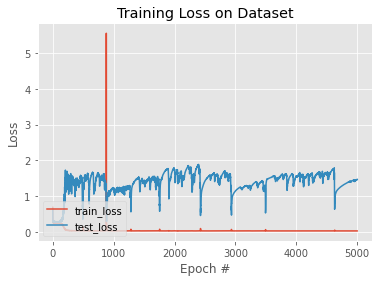

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [15]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # remove gridlines and ticks
    for i in range(3):
        ax[i].grid(False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [16]:
def make_predictions(model, imagePath, threshold = 0.05):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (height, width))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(path_masks, 'mask_'+filename.split('_')[-1].split('.')[0]+'.png')
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
#         print(groundTruthPath)
#         gtMask = cv2.resize(gtMask, (height, width))
        
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > threshold) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


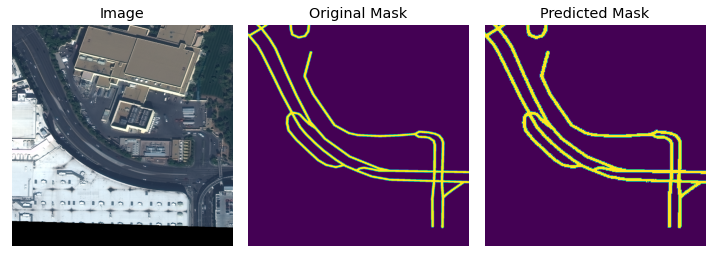

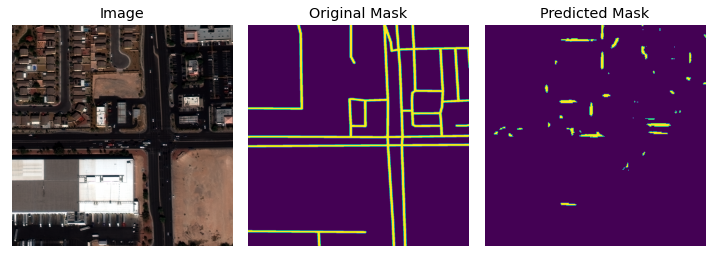

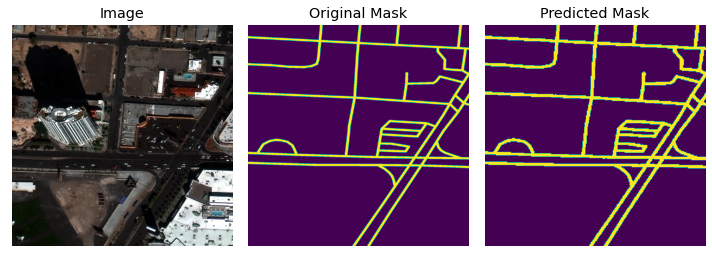

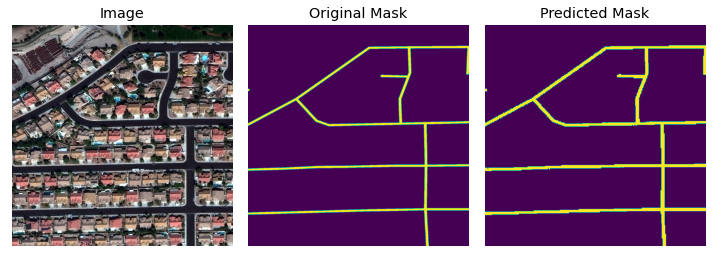

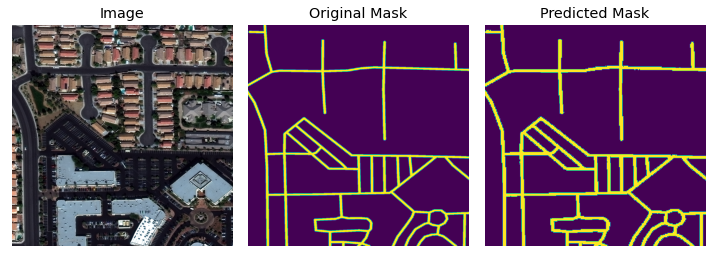

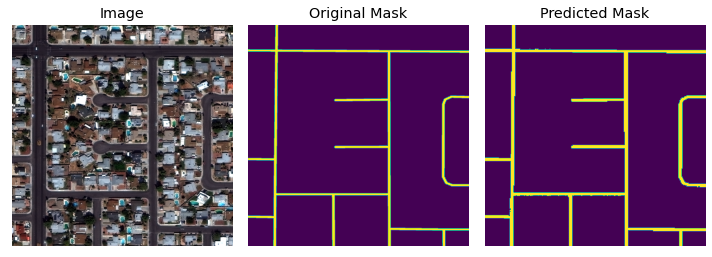

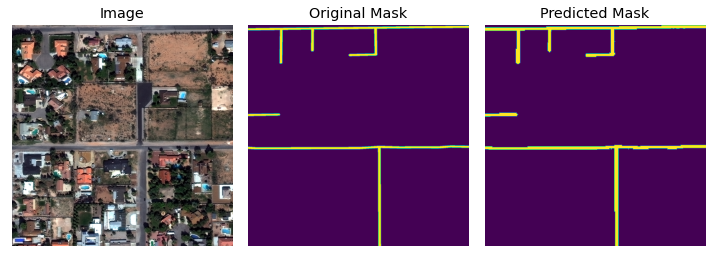

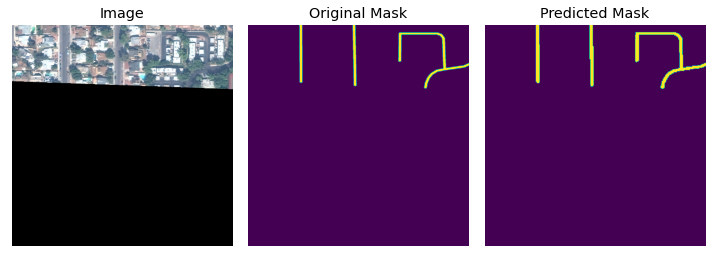

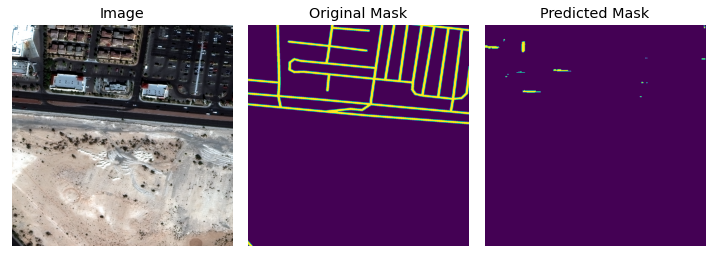

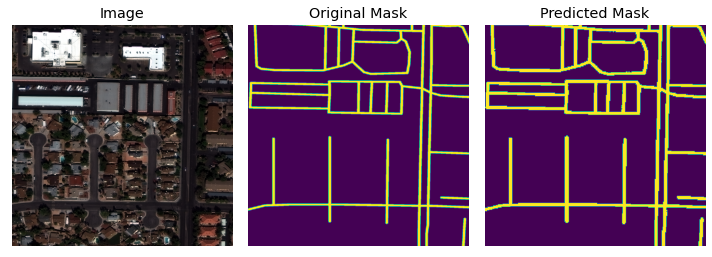

In [17]:
print("[INFO] loading up test image paths...")
# imagePaths = open(test_paths).read().strip().split("\n")
# imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)
# iterate over the randomly selected test image paths
for path in imagePaths:
    make_predictions(unet, path_images+path)

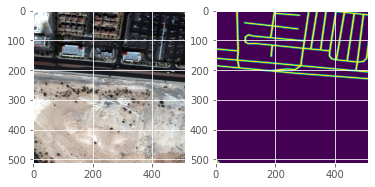

In [18]:
x=iter(testLoader)
t_img, t_lb = next(x)
fig,ax=plt.subplots(1,2)
ax[0].imshow(t_img[0].permute(1,2,0))
ax[1].imshow(t_lb[0][0])

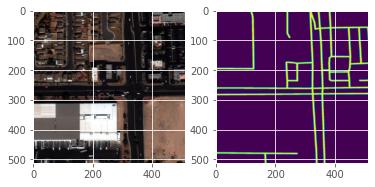

In [19]:
t_img, t_lb = next(x)
fig,ax=plt.subplots(1,2)
ax[0].imshow(t_img[0].permute(1,2,0))
ax[1].imshow(t_lb[0][0])